<a href="https://colab.research.google.com/github/tomcdonald/ml-ai/blob/master/notes/Objective_Functions_and_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective Functions & Supervised Learning

## Perceptron Classification

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

%matplotlib inline

This week, we move away from probability to further discuss the objective function. We will look at a classification example here, using a Perceptron algorithm.

* Our feature matrices are $\mathbf{x_i}$ for the $i$th instance
* This is a binary classification, so the labels $y_i$ take the value -1 or +1

Our prediction function is given as follows:

\begin{equation}f(\mathbf{x_i})=g(z)=sign(z)=sign(\mathbf{w^Tx_i}+b)=\begin{cases}+1 \quad z>0 \\ -1 \quad z<0 \end{cases} \end{equation}

The decision boundary which determines the class of an instance is given by a hyperplane, where the vector $\mathbf{w}$ is the normal vector to the hyperplane.

The hyperplane is given by $\mathbf{w^Tx}=-b$, although sometimes we use $b=w_0$

Text(0, 0.5, '$x_2$')

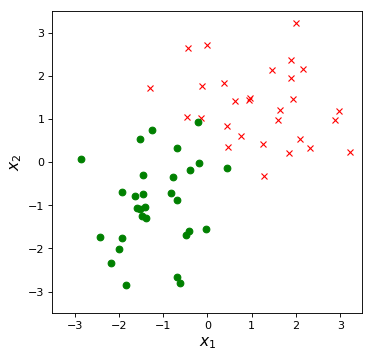

In [2]:
n_data_per_class = 30
np.random.seed(seed=1000001)
x_plus = np.random.normal(loc=1.3, size=(n_data_per_class, 2))
x_minus = np.random.normal(loc=-1.3, size=(n_data_per_class, 2))

# plot data
plt.figure(figsize=(5, 5), dpi=80)
xlim = np.array([-3.5, 3.5])
ylim = xlim
plt.plot(x_plus[:, 0], x_plus[:, 1], 'rx')
plt.plot(x_minus[:, 0], x_minus[:, 1], 'go')
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1]) 
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$x_2$', fontsize=14)

We can draw a hyperplane at the decision boundary to show where a point moves from being classified as -1 to +1. If we expand the prediction function:

\begin{equation} sign(\mathbf{w^Tx_i}+b)=sign(w_1x_{i,1} + w_2x_{i,2}+b) \end{equation}

The equation of the plane defining the decision boundary is given by $w_1x_{i,1} + w_2x_{i,2}+b = 0$ **which can be written as:** 

\begin{equation}w_1x_{i,1} + w_2x_{i,2} = -b\end{equation}

If we select a random data point $\mathbf{x_i}$ from the data, we can check if the current $\mathbf{w}$ and b provide a correct prediction by applying the prediction function, and comparing the output $f(\mathbf{x_i})$ and the true label $y_i$.

In [0]:
# Routine to keep the margins of the drawing box fixed and get the correct margin points for computing the mid points
# later
def margins_plot(x2, xlim, ylim, w, b):
    if (- w[0]/w[1])>0:# cases for a positive slope                
        #xlim = np.flip(xlim, 0)
        #ylim = np.flip(ylim, 0)
        if np.max(x2)>ylim[1] and np.min(x2)<ylim[0]: 
            x_margin_neg = (ylim[1] + (b/w[1]))/(- w[0]/w[1])
            x_margin_pos = (ylim[0] + (b/w[1]))/(- w[0]/w[1])
            y_margin_neg = ylim[1]
            y_margin_pos = ylim[0]
        if np.max(x2)<ylim[1] and np.min(x2)>ylim[0]:
            x_margin_neg = xlim[1]
            x_margin_pos = xlim[0]
            y_margin_neg = (- w[0]/w[1])*xlim[1] - (b/w[1])
            y_margin_pos = (- w[0]/w[1])*xlim[0] - (b/w[1])            
        if np.max(x2)>ylim[1] and np.min(x2)>ylim[0]:
            x_margin_neg = (ylim[1] + (b/w[1]))/(- w[0]/w[1])
            x_margin_pos = xlim[0]
            y_margin_neg = ylim[1]
            y_margin_pos = (- w[0]/w[1])*xlim[0] - (b/w[1])
        if np.max(x2)<ylim[1] and np.min(x2)<ylim[0]:
            x_margin_neg = xlim[1]
            x_margin_pos = (ylim[0] + (b/w[1]))/(- w[0]/w[1])
            y_margin_neg = (- w[0]/w[1])*xlim[1] - (b/w[1]) 
            y_margin_pos =  ylim[0]                  
    else:    
        if np.max(x2)>ylim[1] and np.min(x2)<ylim[0]: 
            x_margin_neg = (ylim[0] + (b/w[1]))/(- w[0]/w[1])
            x_margin_pos = (ylim[1] + (b/w[1]))/(- w[0]/w[1])
            y_margin_neg = ylim[0]
            y_margin_pos = ylim[1]            
        if np.max(x2)<ylim[1] and np.min(x2)>ylim[0]:         
            x_margin_neg = xlim[1]
            x_margin_pos = xlim[0]
            y_margin_neg = (- w[0]/w[1])*xlim[1] - (b/w[1])
            y_margin_pos = (- w[0]/w[1])*xlim[0] - (b/w[1])
        if np.max(x2)>ylim[1] and np.min(x2)>ylim[0]:
            x_margin_neg = xlim[1]
            x_margin_pos = (ylim[1] + (b/w[1]))/(- w[0]/w[1])
            y_margin_neg = (- w[0]/w[1])*xlim[1] - (b/w[1])
            y_margin_pos = ylim[1]   
        if np.max(x2)<ylim[1] and np.min(x2)<ylim[0]:
            x_margin_neg = (ylim[0] + (b/w[1]))/(- w[0]/w[1])
            x_margin_pos = xlim[0]
            y_margin_neg = ylim[0]
            y_margin_pos = (- w[0]/w[1])*xlim[0] - (b/w[1]) 
    return x_margin_neg, x_margin_pos, y_margin_neg, y_margin_pos 

# Routine for plotting
def plot_perceptron(w, b):
    npoints = 100
    xlim = np.array([-3.5, 3.5])
    ylim = xlim
    x1 = np.linspace(xlim[0], xlim[1], npoints)
    x2 = (- w[0]/w[1])*x1 - (b/w[1])
    x_margin_neg, x_margin_pos, y_margin_neg, y_margin_pos = margins_plot(x2, xlim, ylim, w, b)
    x1c = (x_margin_neg + x_margin_pos)/2
    x2c = (y_margin_neg + y_margin_pos)/2
    x2per = (w[1]/w[0])*x1 - (w[1]/w[0])*x1c + x2c
    #plt.axes()
    display.clear_output(wait=True)
    plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(x_plus[:, 0], x_plus[:, 1], 'rx')
    plt.plot(x_minus[:, 0], x_minus[:, 1], 'go')    
    plt.xlabel(r'$x_1$', fontsize=14)
    plt.ylabel(r'$x_2$', fontsize=14)
    plt.plot(x1, x2, 'b')
    #plt.plot(x1, x2per, '--k', color='whitesmoke')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])    
    plt.arrow(x1c, x2c, w[0], w[1], width=0.03, head_width=0.3, head_length=0.3, fc='k', ec='k') 
    #display.display(plt.gcf())

Now we can initialise the decision boundary:

The sign for the selected value is  1.0


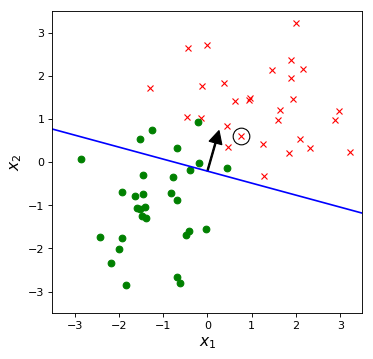

In [4]:
#np.random.seed(seed=1001)
w = 0.5*np.random.randn(2)
b = 0.5*np.random.randn()
plot_perceptron(w, b)
x_selected = x_plus[1]
plt.plot(x_selected[0], x_selected[1], 'o', mfc='none', mec='k', ms=15, lw=5)
print("The sign for the selected value is ", np.sign(np.dot(w, x_selected)+b))

#### Drawing the Decision Boundary

As mentioned previously, the decision boundary is where the prediction function output flips from -1 to +1, representing the location at which the sign function argument is zero. As this dataset is two dimensional, the boundary is a straight line, but in 3D or higher dimensional datasets, the decision boundary is actually a hyperplane, hence why the decision boundary is often known as the *separating hyperplane*.

Plotting the boundary in 2D is relatively simple, as for each value of $x_1$ on the boundary, we simply find the corresponding value of $x_2$ by rearranging the hyperplane formula to give:

\begin{equation}x_2 = -\frac{(b+x_1w_1)}{w_2} \end{equation}

Or alternatively we can choose to specify $x_2$ and calculate $x_1$:

\begin{equation}x_1 = -\frac{(b+x_2w_2)}{w_1} \end{equation}

Which equation we use depends on how the separating hyperplane leaves the plot; if the hyperplane leaves the top and bottom of the plot we'll want to plot a line for all values in the $y$ direction (given by $x_2$), computing $x_1$ for each of these, so that the boundary covers the entire plot. If the line leaves the sides of the plot, then we'll do the opposite, using all values of $x_1$ and calculating $x_2$ for each.

#### Perceptron Algorithm

In [0]:
def update_perceptron(w, b, x_plus, x_minus, learn_rate):
    "Update the perceptron."
    # select a point at random from the data
    choose_plus = np.random.uniform(size=1)>0.5
    updated=False
    if choose_plus:
        # choose a point from the positive data
        index = np.random.randint(x_plus.shape[0])
        x_select = x_plus[index, :]
        if np.dot(w, x_select)+b <= 0.:
            # point is currently incorrectly classified
            w += learn_rate*x_select
            b += learn_rate
            updated=True
    else:
        # choose a point from the negative data
        index = np.random.randint(x_minus.shape[0])
        x_select = x_minus[index, :]
        if np.dot(w, x_select)+b > 0.:
            # point is currently incorrectly classified
            w -= learn_rate*x_select
            b -= learn_rate
            updated=True
    return w, b, x_select, updated

We want to find the parameters $\mathbf{w}$ and b which allow a correct prediction for a datapoint $\mathbf{x_i}$. This can be achieved by writing an algorithm whereby, if the vector $\mathbf{x_i}$ is classified correctly, we don't change the parameters, but if the vector is incorrectly classified, we change those parameters by adding a correction term, with the hope that this will improve the model.

Specifically:

* If $\mathbf{x_i}$ is incorrectly classified as negative when it's actually positive, we add $\eta\mathbf{x_i}$ to $\mathbf{w}$ and $\eta$ to b.

* If $\mathbf{x_i}$ is incorrectly classified as positive when it's actually negative, we subtract $\eta\mathbf{x_i}$ from $\mathbf{w}$ and $\eta$ from b.

* $\eta$ is called the learning rate; increasing this will result in larger correction 'jumps'.

#### Example of Training Step
If $\mathbf{x_i}$ has label $y_i = +1$, but $\mathbf{w}$ and $b$ are such that the prediction returned is $f(\mathbf{x_i}) = -1$, then we will apply the correction terms to the model parameters as follows:

\begin{equation}\mathbf{w_{new}} = \mathbf{w} + \eta \mathbf{x_i}  \\
b_{new} = b + \eta \end{equation}
<br>
Therefore, the new predicted value will be given by:
<br>
<br>
\begin{equation}f(\mathbf{x_i}) = sign(\mathbf{w_{new}}^{\top}\mathbf{x_i} + b_{new}) \\ \qquad\qquad
               = sign((\mathbf{w}+\eta \mathbf{x}_i)^{\top}\mathbf{x}_i +  b + \eta)\\\qquad\qquad
               = sign(\mathbf{w}^{\top}\mathbf{x}_i + b +\eta \mathbf{x}_i^{\top}\mathbf{x}_i + \eta)\end{equation}

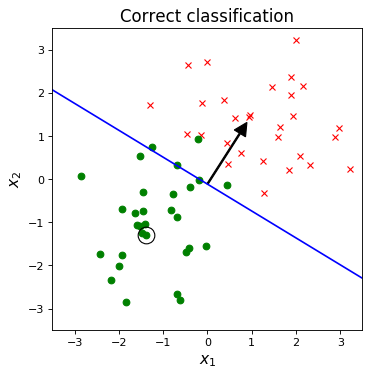

In [6]:
def run_perceptron(w, b, learn_rate, how_many):
    for i in range(how_many):   
        plot_perceptron(w, b) 
        w, b, x_selected, updated = update_perceptron(w, b, x_plus, x_minus, learn_rate)
        plt.plot(x_selected[0], x_selected[1], 'o', \
             mfc='none', mec='k', ms=15, lw=5)
        if updated:
            plt.title('Incorrect classification: needs updating', {'fontsize': 15})
            plt.pause(5)
        else:
            plt.title('Correct classification', {'fontsize': 15})
            plt.pause(2)
            
niters = 20
learn_rate = 0.5
run_perceptron(w, b, learn_rate, niters)

#### Perceptron Reflection

The perceptron algorithm works well and converges, but only for problems which are linearly separable (i.e. it's possible for a line to separate the classes, which is only possible where the classes don't overlap).

To solve problems which are not linearly separable, we must look towards other solutions, multi-layered perceptron algorithms being one option.

The update equations come from first defining the objective function, perceptron criterion and then optimising it in order to minimise the amount of incorrect predictions. Objective functions are also known as *loss functions, error functions or cost functions*.

## Regression & Gradient Descent

Here we see an example of the training process not for a classification problem, but for a regression problem, where our prediction function is:

\begin{equation}f(x_i) = mx_i +c\end{equation}

and to fit the data we minimize the error using the least squares algorithm.

(-3, 3)

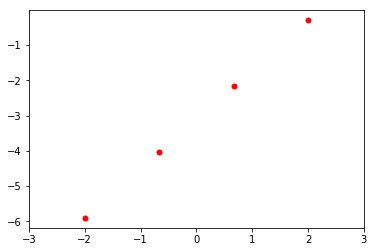

In [7]:
# create artifical data
np.random.seed(seed=1001)
#x = np.random.normal(size=4)
x = np.linspace(-2,2, 4)

# decide on true values for m and c, used to generate data
m_true = 1.4
c_true = -3.1

y = m_true*x+c_true

# plot the artificial data
plt.plot(x, y, 'r.', markersize=10) # plot data as red dots
plt.xlim([-3, 3])

A straight line is a perfect scenario, so we corrupt them slightly with some Gaussian noise:

(-3, 3)

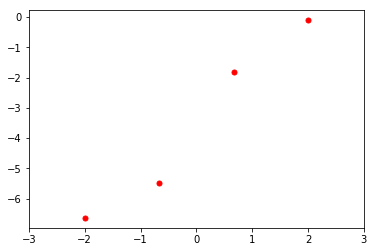

In [8]:
np.random.seed(seed=22050)
noise = np.random.normal(scale=0.5, size=4) # standard deviation of the noise is 0.5
y = m_true*x + c_true + noise
plt.plot(x, y, 'r.', markersize=10)
plt.xlim([-3, 3])

Now, we can visualise the error function surface, creating vectors of the values. We create a grid of these values to evaluate the function in 2D, computing the error function for each combination of c and m.

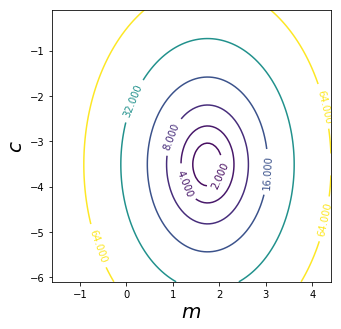

In [9]:
# create an array of linearly separated values around m_true
m_vals = np.linspace(m_true-3, m_true+3, 100) 
# create an array of linearly separated values ae
c_vals = np.linspace(c_true-3, c_true+3, 100)

m_grid, c_grid = np.meshgrid(m_vals, c_vals)


E_grid = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        E_grid[i, j] = ((y - m_grid[i, j]*x - c_grid[i, j])**2).sum()
        
# create the contour plot
# %load -s regression_contour teaching_plots.py
def regression_contour(f, ax, m_vals, c_vals, E_grid):
    "Regression contour plot."
    hcont = ax.contour(m_vals, c_vals, E_grid, levels=[0, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]) # this makes the contour plot    
    plt.clabel(hcont, inline=1, fontsize=10) # this labels the contours.

    ax.set_xlabel('$m$', fontsize=20)
    ax.set_ylabel('$c$', fontsize=20)
    
f, ax = plt.subplots(figsize=(5,5))
regression_contour(f, ax, m_vals, c_vals, E_grid)

So our key goal when training this model should be to minimise the sum of squares error function, and a way of achieving this is by using *gradient descent*. We initialise with a guess for $m$ and $c$, and update that guess by subtracting a portion of the gradient at that point, from the guess.

Conceptually, it's equivalent to walking down a hill in the steepest direction in order to reach the bottom.

We begin with guessed values for our parameters:

In [0]:
m_star = 0.0
c_star = -5.0

And now, we must compute the gradient of the error function, firstly with respect to $c$. As the error function is given by:

\begin{equation}E(m,c) =\sum_{i=1}^n (y_i - mx_i -c)^2 \end{equation}

the derivative wrt. $c$ is given by:

\begin{equation}\frac{dE(m,c)}{dc} =-2\sum_{i=1}^n (y_i - mx_i -c) \end{equation}

*(Note that since c appears in every term in the sum, we are just computing the derivative of the interior of the sum, for every term from $i$ to $n$, and the sum then remains in the computed gradient.)*

In [11]:
c_grad = -2*(y-m_star*x - c_star).sum()
print("Gradient with respect to c is ", c_grad)

Gradient with respect to c is  -11.925855741055683


We undertake a similar process to find the slope gradient, which is given by:

\begin{equation} \frac{dE(m,c)}{dm} = -2\sum_{i=1}^n x_i(y_i -mx_i -c) \end{equation}

In [12]:
m_grad = -2*(x*(y-m_star*x - c_star)).sum()
print("Gradient with respect to m is ", m_grad)

Gradient with respect to m is  -31.02396584223549


Now we have both gradients, we can update our guessed parameters, but we don't simply subtract the gradients from the parameters, we multiply them by a small number in order to ensure that whilst we're taking a step in the right direction, we're not overshooting the minimum. The gradient constantly changes so we'll need to update the gradients at each descent step.

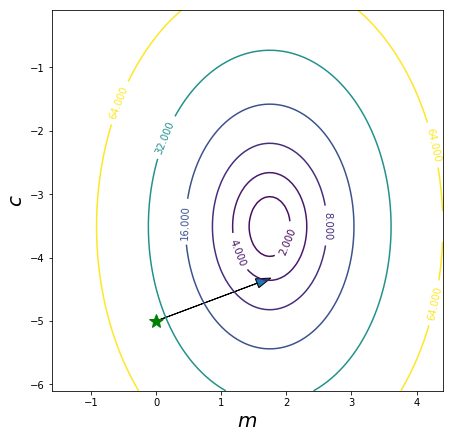

In [13]:
# move in gradient direction
f, ax = plt.subplots(figsize=(7,7))
regression_contour(f, ax, m_vals, c_vals, E_grid)
ax.plot(m_star, c_star, 'g*', markersize=15)
ax.arrow(m_star, c_star, -m_grad*0.05, -c_grad*0.05, head_width=0.15)

The step size (0.05 in the code block above), has already been introduced as the learning rate $\eta$. Updating our equations gives us the new values:

\begin{equation} c_{new}\leftarrow c_{old}-\eta\frac{dE(m,c)}{dc} \end{equation} \\
\begin{equation} m_{new}\leftarrow m_{old}-\eta\frac{dE(m,c)}{dm} \end{equation}

Which we can update in Python as follows:

In [14]:
print("Original m was", m_star, "and original c was", c_star)
learn_rate = 0.01
c_star = c_star - learn_rate*c_grad
m_star = m_star - learn_rate*m_grad
print("New m is", m_star, "and new c is", c_star)

Original m was 0.0 and original c was -5.0
New m is 0.3102396584223549 and new c is -4.880741442589443


And in order to fit the model optimally, we must perform a number of iterations of this process, until we have arrived at (or thereabouts) the minimum:

Iteration 20 Objective function: 1.1095.


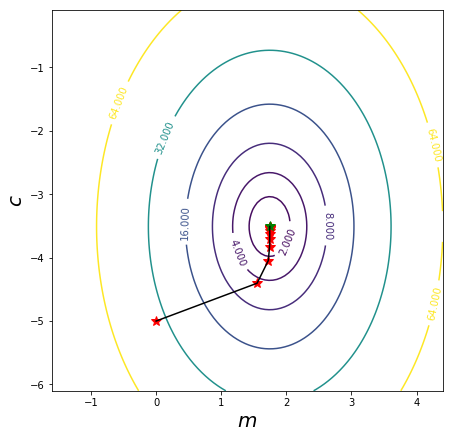

In [15]:
def plot_regression_contour_fit(f, ax, x, y, learn_rate = 0.1, iters = 10):
    m_star = 0.0
    c_star = -5.0
    E = np.empty(iters+1)
    E[0] = ((y - m_star*x - c_star)**2).sum()
    regression_contour(f, ax, m_vals, c_vals, E_grid)
    ax.plot(m_star, c_star, 'g*', markersize=10)
    plt.pause(1.5)
    c_vec = c_star
    m_vec = m_star
    for i in range(iters):
        c_grad = -2*(y-m_star*x - c_star).sum()
        m_grad = -2*(x*(y-m_star*x - c_star)).sum()       
        #c_ant = c_star
        #m_ant = m_star                
        c_star = c_star - learn_rate*c_grad
        m_star = m_star - learn_rate*m_grad
        c_vec = np.append(c_vec, c_star)
        m_vec = np.append(m_vec, m_star)
        display.clear_output(wait=True)
        f, ax = plt.subplots(figsize=(7,7))
        regression_contour(f, ax, m_vals, c_vals, E_grid)
        ax.plot(m_vec[0:m_vec.shape[0]-1], c_vec[0:c_vec.shape[0]-1], 'r*', markersize=10)
        ax.plot(m_star, c_star, 'g*', markersize=10)
        ax.plot(m_vec, c_vec, 'k')              
        E[i+1] = ((y - m_star*x - c_star)**2).sum()
        print("Iteration {} Objective function: {:02.4f}.".format(i+1, E[i+1]))
        plt.pause(1.2)
    return m_star, c_star

f, ax = plt.subplots(figsize=(5,5), dpi=80)
m_star, c_star = plot_regression_contour_fit(f, ax, x, y, learn_rate = 0.05, iters=20)

In [16]:
print("The true value for the slope m is {:02.4f}. The estimated value is {:02.4f}.\n".format(m_true, m_star))
print("The true value for the intersect c is {:02.4f}. The estimated value is {:02.4f}.\n".format(c_true, c_star))

The true value for the slope m is 1.4000. The estimated value is 1.7451.

The true value for the intersect c is -3.1000. The estimated value is -3.5093.



For small $n$ (the number of datapoints), gradient descent works well, but often in ML problems, $n$ is enormous. In such situations **stochastic gradient descent** can be preferable; in SGD, instead of using lots of computational power to compute and sum the gradients across all of the data points, we look at gradients of random data points one at a time instead.

We know that the gradient wrt. $m$ is given by:

\begin{equation} \frac{dE(m,c)}{dm} = -2\sum_{i=1}^n x_i(y_i -mx_i -c) \end{equation}

and that the update equation is of the form:

\begin{equation} m_{new}\leftarrow m_{old}-\eta\frac{dE(m,c)}{dm}\\ \end{equation}

therefore subsituting in the gradient, we can see the full update is of the form:

\begin{equation} m_{new}\leftarrow m_{old}+2\eta\sum_{i=1}^n x_i(y_i -mx_i -c) \end{equation}

which can be written as:
<br>
<br>
\begin{equation}m_{new} \leftarrow m_{old} + 2\eta \left[x_1 (y1 - m_{old}x1 - c_{old})
 + (x_2 (y_2 -   m_\text{old}x_2 - c_\text{old}) + \dots + (x_n (y_n - m_\text{old}x_n - c_\text{old})\right]\end{equation}
<br>
Much like for the Perceptron, we can present each data point in a random order. This makes the algorithm suitable for large scale applications ('Big Data').

As the data is generally in a random order, we can simplify the formula for SGD and simply write:
<br>
<br>
\begin{equation} m_{new}=m_{old}+2\eta{x_i(y_i-m_{old}x_i-c_{old})}\end{equation}

#### Reflections on Regression

* The SGD process doesn't provide many advantages for a small data set, it's power really comes from it's ability to scale, as it uses a small randomly selected subset of datapoints as opposed to using the entire dataset to update the gradients.

* The learning rate is key, as if it is too small then the algorithm is unlikely to converge quickly, or at all as the steps will be too small, but if it is too high, then the training steps are likely to overshoot the minimum, and similarly, are unlikely to result in a solution which converges on the global minimum, the parameter values will simply bounce around the minimum.

* However, a small learning rate is more palatable with regular ('steepest') gradient descent, as eventually, the algorithm should converge to the optimal parameters since the entire dataset is being used. Conversely, with SGD, due to the random nature of datapoint selection, a learning rate which is too small is more likely to result in the algorithm not converging on an optimal solution.

* A often used technique in SGD is initially setting the learning rate to a (relatively) high value, and then allowing it to decay/steadily reduce in magnitude as the training process goes on, allowing the algorithm to take advantage of obvious early signals during the first stages of training, but then allowing more careful exploration of the local error surface surrounding the global minimum in the latter stages.